# QFF2025@Science Tokyo ハンズオンDay2

このノートブックはQiskit Fall Fest 2025@Science Tokyoの2日目のハンズオン資料です

Day2の演習では量子アルゴリズムのひとつであるGroverのアルゴリズムについて実装を通して学んでいきます

本演習資料はQuantum Tokyoが公開している[Qiskit Handson資料](https://github.com/quantum-tokyo/qiskit-handson/blob/master/handson-contents/9_grover.ipynb)が元になっています

#### 参考文献

- Eric R. Johnston、Nic Harrigan、Mercedes Gimeno-Segovia著、北野 章訳、丸山 耕司技術監修『動かして学ぶ量子コンピュータプログラミング』, オーム社
- 情報処理学会出版委員会監修, 嶋田 義皓著『量子コンピューティング: 基本アルゴリズムから量子機械学習まで』, オーム社
- Michael A. Nielsen, Isaac L. Chuang著『Quantum Computation and Quantum Information: 10th Anniversary Edition』, Cambridge University Press

<img src="images/Cat_02.png" width="500" />

## 必要なライブラリのインストール

本ハンズオンでは、量子回路の実装や量子計算のシミュレータとしてQiskitが提供するツール群を利用します

利用するライブラリの機能について簡単に紹介します

- `qiskit[visualization]`: 測定結果をヒストグラムで表示したり、量子状態や量子回路の可視化を行うライブラリです
- `qiskit-ibm-runtime`: シミュレータやIBMの実機に接続して回路の測定結果を取得するサンプラーを提供するライブラリです
- `qiskit-aer`: Qiskitが提供する高性能な量子コンピュータシミュレータです。現実的なノイズモデルを組み込むこともできます

In [2]:
!pip install 'qiskit[visualization]' qiskit-ibm-runtime qiskit-aer

## 必要な関数やクラスのインポート

ハンズオンに必要な関数やクラスをインポートします。それぞれの機能はハンズオンを通して説明しますが、ここでも簡単に紹介します

- `QuantumCircuit`: Qiskitで量子回路を表現するときに使うクラス（[API References](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.QuantumCircuit)）
- `AerSimulator`: 高性能な量子コンピュータシミュレータ（[API Documentation](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html#aersimulator)）
- `generate_preset_pass_manager`: 量子回路を量子コンピュータ上で実行可能な形に変形するためにの機能を提供するクラス ([API References](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.generate_preset_pass_manager))
- `SamplerV2`: シミュレータや実機など量子回路を実行するバックエンドのインターフェースとしてサンプリングを行うクラス([API References](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/sampler-v2))
- `plot_histogram`: 測定結果をヒストグラムで可視化するためので可視化するための関数([API References](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.visualization.plot_histogram))

In [44]:
# 既存のインポートの前に追加
import importlib
import sys

# grader モジュールをクリア（以前キャッシュされたものを削除）
if 'grader' in sys.modules:
    del sys.modules['grader']

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from grader import Grader

In [45]:
grader = Grader()

# Groverのアルゴリズム

講義パートで紹介したGroverのアルゴリズムを実際に実装していきます。Groverのアルゴリズム全体を表す量子回路はやや複雑ですが、ステップバイステップで丁寧に見ていきます。


ここでは、簡単のために2量子ビットで考えることにします。スライドでも具体例として紹介した、$\ket{11}$を取り出す問題を考えます。

最終的な回路は以下のようになります。この回路では、計算結果として$\ket{11}$のみが出力されます。これを目指して一つずつ回路を組んでみましょう！

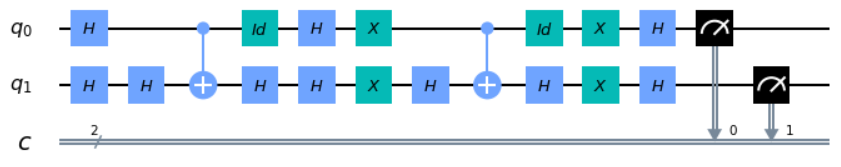

## Step1:量子ビットと古典ビットの準備

どんな量子アルゴリズムも量子ビットの準備から始まります

Qiskitを使って量子回路を記述するときは、最初に量子ビットと古典ビットの数を宣言することに注意してください。量子ビット数が $m$ 、古典ビット数が $n$ 個のとき、量子回路を表すクラスを次のように宣言します

```python
circuit = QuantumCircuit(m, n)
```

<div class="alert alert-block alert-info">

<b>TIPs</b>

ここでは量子ビット数と古典ビット数をそれぞれ $m,n$ と表しましたが、多くの場合は量子ビット数と古典ビット数は同じになります。なぜなら、古典ビットは測定結果の格納のために使い、ほとんどの量子ビットは最終的に測定されるからです。

1つの量子ビットに対して複数回の測定を行う場合は古典ビットの数が量子ビット数よりも多くなります

</div>


<div class="alert alert-box alert-success">

<b>演習1：量子ビットと古典ビットの準備</b>

このことを参考にして、2つの量子ビットと2つの古典ビットからなる量子回路を宣言してください

</div>



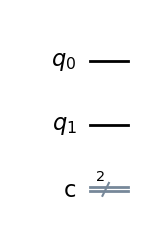

In [25]:
# 演習1

### ここから下にコードを書いてください

grover_ex_1 = QuantumCircuit(2, 2)

### ここより上にコードを書いてください

grover_ex_1.draw(output='mpl')

In [26]:
grader.grover_ex_1(grover_ex_1)

正解です！


True

## Step2: 重ね合わせ状態の作成

多くの量子アルゴリズムでは一番最初に重ね合わせ状態を生成します。

全ての状態が起こりうる重ね合わせの状態を作りましょう。Day1でも紹介しましたが、すべての量子ビットに対してそれぞれアダマールゲートを作用させることで、すべての状態が重ね合わせになった状態を作ることができます。

今回の例では量子ビットが2つあるので、0番目の量子ビットと1番目の量子ビットにそれぞれアダマールゲートを作用させれば十分です

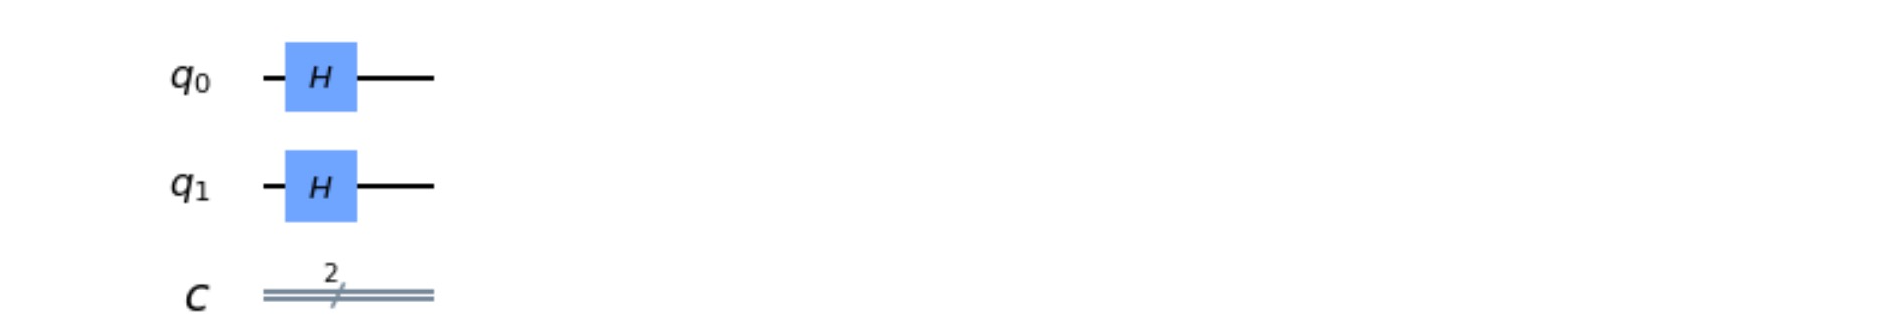

<div class="alert alert-box alert-success">

<b>演習2: 重ね合わせ状態の生成</b>

演習1で作成した量子回路に対して適切なゲートを作用させることで、すべての状態が重ね合わせになった状態を作成してください

</div>

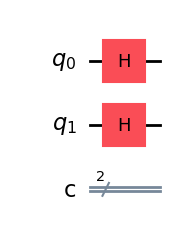

In [32]:
# 演習2 

grover_ex_2 = QuantumCircuit(2, 2)

### ここから下にコードを書いてください

grover_ex_2.h(0)
grover_ex_2.h(1)

### ここより上にコードを書いてください

grover_ex_2.draw(output='mpl')

In [33]:
grader.grover_ex_2(grover_ex_2)

正解です！


True

Day1で紹介した通り、アダマールゲートを用いて生成される、すべての状態が重ね合わされた状態はCircle notationを用いることで次のように表現できます

<img src="images/circle_nonation.png" width="700" />
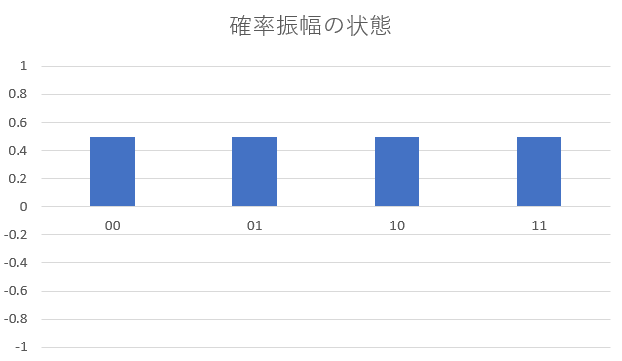

## Step3: オラクルの実装

Groverのアルゴリズムを構成する2つの要素のひとつ、オラクルを実装します

今回の例ではすべての状態の中から $\ket{11}$ の位相だけを反転させます。つまり、

$$f(x) = \begin{cases}1 & x = 11 \\ 0 & \text{otherwise}\end{cases}$$

で定義される関数 $f(x)$ を用いて、オラクル $U_{\omega}$ は

$$U_{\omega}\ket{x} = (-1)^{f(x)} \ket{x}$$

と表す事ができます。これを実現する回路をどのように実装すればいいでしょうか？

Day1で学んだ内容をよく振り返ってみましょう。

- Zゲートは $\ket{1}$ 状態の位相を反転するゲート
- CZゲートは制御量子ビットの状態が $\ket{1}$ のときターゲット量子ビットに Zゲートを作用させる
- (CZゲートはアダマールゲートとCNOTゲートを組み合わせることで構成できる)

実装のためのヒントがコードブロックの直後にあります。昨日の復習をしたい人は利用してください

<div class="alert alert-box alert-success">

<b>演習3: オラクルの実装</b>

次のような操作を行う量子ゲートを実装し、演習2までで作成した量子回路に追加してください

$$U_{\omega} \ket{x} = \begin{cases}- \ket{x} & x = 11 \\ \ket{x} & \text{otherwise}\end{cases}$$

</div>

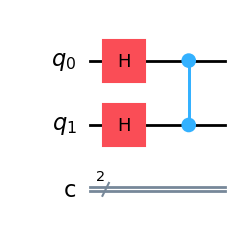

In [36]:
# 演習3

grover_ex_3 = QuantumCircuit(2, 2)
grover_ex_3.h(0)
grover_ex_3.h(1)

### ここから下にコードを書いてください

grover_ex_3.cz(0, 1)

### ここより上にコードを書いてください

grover_ex_3.draw(output='mpl')

In [37]:
grader.grover_ex_3(grover_ex_3)

正解です！


True

<div class="alert alert-box">

<b>演習3のヒント</b>

演習3の最も単純な解法はCZゲートを1つ作用させる方法です。CZゲートは2つの量子ビットにまたがる量子ゲートなので、2つの量子ビットを指定する必要があります。さらに、片方の量子ビットは制御用の量子ビットでありもう片方がターゲット量子ビットになるので、インデックスを指定する順番に注意しましょう。

$i$ 番目の量子ビットを制御量子ビットとして、 $j$ 番目の量子ビットをターゲット量子ビットとしたい場合、CZゲートは次のように追加します

```py
circuit.cz(i, j)
```

2つ目の解法として、アダマールゲートとCNOTゲートを使ってCZゲートを実装する方法があります。CNOTゲートとCZゲートの違いは、ターゲット部分がXゲートかZゲートかという違いのみです。さらに、

$$Z = HXH$$

という関係があり、アダマールゲートとXゲートを使ってZゲートを表現できます。このことを応用すると、CZゲートが次のように、アダマールゲートとCNOTゲートを使って実装できることがわかります。

<img src="images/cz_gate.png" width="700" />

</div>

講義パートで紹介したように、オラクルを作用させることで $\ket{11}$ の位相のみが反転します。これをCircle notationで表現すると次のようになります

<img src="images/circle_notation_oracle.png" width="700" />

## Step4: 振幅増幅の実装

Groverのアルゴリズムを構成する要素の2つ目、振幅増幅を実装します

振幅増幅は、位相差の情報を振幅の差に変換する操作でした。また、その仕組は「振幅の平均について振幅を反転させる」というものでした

これを実現するために、次のようにかける量子ゲートを作成します

$$U_{s} = 2\ket{s}\bra{s} - I$$

$$\ket{s} = \sum_{i=0}^{2^n-1} \frac{1}{\sqrt{2}^n} \ket{i}$$

これは一般的な形なので、今回の2量子ビットに関する具体例をみると、

$$U_s = 2 \left(\sum_{i=0}^{3} \frac{1}{2} \ket{i}\right) \left(\sum_{i=0}^{3} \frac{1}{2}\bra{i}\right) - I$$

となります。これはやや複雑で、1から実装することが難しいので結論だけ先に示します。興味がある方はコードブロックの直後にある導出過程も確認してみてください

（図に含まれるIゲートは見た目を整えるために追加されています。何もしないゲートなのでなくても正しく動作します）
<img src="images/amplitude_circuit.png" width="700" />

<div class="alert alert-box alert-success">

<b>演習4: 振幅増幅の実装</b>

振幅増幅を表す上の回路を、演習3までで作成した量子回路に追加してください

</div>

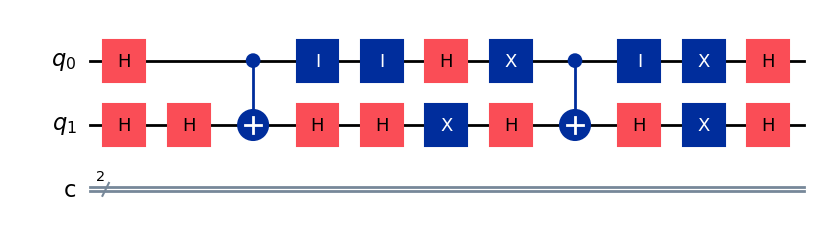

In [46]:
# 演習4

grover_ex_4 = QuantumCircuit(2, 2)
grover_ex_4.h(0)
grover_ex_4.h(1)
grover_ex_4.h(1)
grover_ex_4.cx(0,1)
grover_ex_4.h(1)

### ここから下にコードを書いてください

grover_ex_4.id(0) # 回路の見た目を整えるために何もしないことを表すIゲートを入れています
grover_ex_4.id(0) # 回路の見た目を整えるために何もしないことを表すIゲートを入れています
grover_ex_4.h(0)
grover_ex_4.h(1)   
grover_ex_4.x(0)
grover_ex_4.x(1)
grover_ex_4.h(1)
grover_ex_4.cx(0,1)
grover_ex_4.id(0) # 回路の見た目を整えるために何もしないことを表すIゲートを入れています
grover_ex_4.h(1)
grover_ex_4.x(0)
grover_ex_4.x(1)
grover_ex_4.h(0)
grover_ex_4.h(1)

### ここより上にコードを書いてください

grover_ex_4.draw(output='mpl')

In [47]:
grader.grover_ex_4(grover_ex_4)

正解です！


True

<div class="alert alert-box">

<b>振幅増幅の回路の導出</b>

$$\sum_{i=0}^{3} \frac{1}{2} \ket{i} = H_1H_0 \ket{00}$$

であることを利用すると、振幅増幅の操作は次のように書き換えることができます

$$U_s = H_1H_0 (2\ket{00}\bra{00} - I) H_1H_0$$

さらに、この式に登場する $2\ket{00}\bra{00} - I$ は行列で表現すると

$$2\ket{00}\bra{00} - I = \begin{pmatrix} 1&0&0&0 \\ 0&-1&0&0 \\ 0&0&-1&0 \\ 0&0&0&-1\end{pmatrix}$$

これに近いゲートとしてCZゲートがあります。CZゲートの行列表現は

$$\begin{pmatrix} 1&0&0&0 \\ 0&1&0&0 \\ 0&0&1&0 \\ 0&0&0&-1 \end{pmatrix}$$

です。CZゲートから $2\ket{00}\bra{00} - I$ を構成するためには、

- 2つの量子ビットにそれぞれXゲートを作用させて、対角成分を入れ替える
- CZゲートを作用させる
- 2つの量子ビットにそれぞれXゲートを作用させて、対角成分をもとに戻す
- (全体に$-1$をかける。ただし、これはグローバル位相を変えるだけなのでなくてもいい)

という操作をすればいいです。したがって、

$$U_s = H_1H_0 (X_1X_0 CZ X_1X_0) H_1H_0$$

となります

</div>

## Step5: 測定

量子アルゴリズムはどんなものでも測定によって終わります

今回のアルゴリズムでは2つの量子ビットがあるので、それぞれについて測定を行うことでアルゴリズムの結果を読み出します

測定の操作は、測定する量子ビットと測定結果を格納する古典ビットを指定することで宣言できます。具体的には、$i$ 番目の量子ビットの測定結果を $j$ 番目の古典ビットに格納したい場合、

```python
circuit.measure(i, j)
```

とすることで測定の操作を追加できます。

<div class="alert alert-box alert-success">

<b>演習5: 測定</b>

演習4までで作成した量子回路に対して、各量子ビットの測定の操作を追加してください

</div>

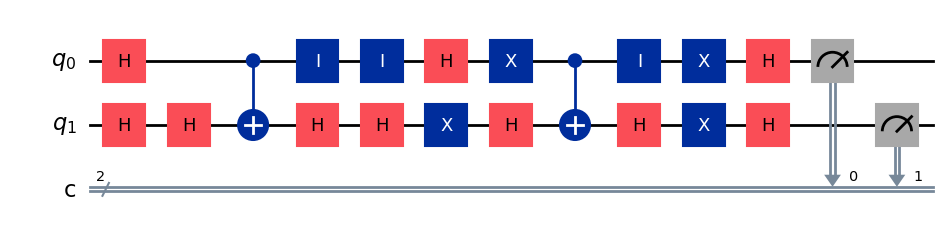

In [48]:
grover_ex_5 = QuantumCircuit(2, 2)
grover_ex_5.h(0)
grover_ex_5.h(1)
grover_ex_5.h(1)
grover_ex_5.cx(0,1)
grover_ex_5.h(1)
grover_ex_5.id(0)
grover_ex_5.id(0)
grover_ex_5.h(0)
grover_ex_5.h(1)   
grover_ex_5.x(0)
grover_ex_5.x(1)
grover_ex_5.h(1)
grover_ex_5.cx(0,1)
grover_ex_5.id(0)
grover_ex_5.h(1)
grover_ex_5.x(0)
grover_ex_5.x(1)
grover_ex_5.h(0)
grover_ex_5.h(1)

### ここから下にコードを書いてください

grover_ex_5.measure(0,0)
grover_ex_5.measure(1,1)

### ここより上にコードを書いてください

grover_ex_5.draw(output='mpl')

In [49]:
grader.grover_ex_5(grover_ex_5)

正解です！


True

目標とする回路と一致しましたか？
では、計算を実行してみましょう。状態$\ket{11}$のみが出力されていれば、目的を達成できています。

測定結果のカウント: {'11': 5000}


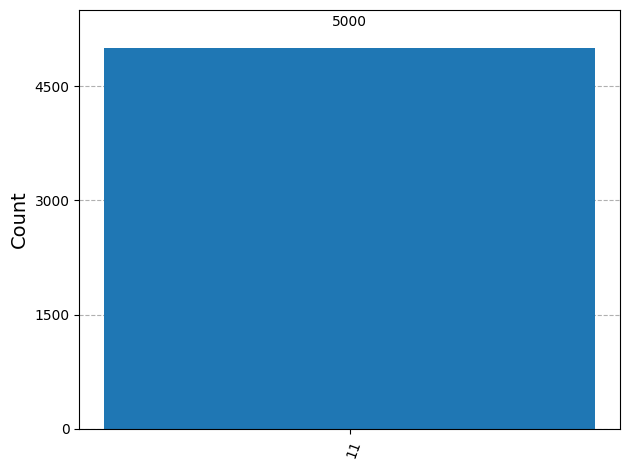

In [15]:
# 3. 測定
grover_ex_5.measure_all()
# シミュレーターの決定 
# 今回は実際の量子コンピューターではなくて，それを擬似的にシミュレーションするバックエンドを使います
backend = AerSimulator()

# 実機に対応する最適化などを行う設定
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# 最適化された量子回路の作成
isa_grover_ex_5 = pm.run(grover_ex_5)
# サンプラーの決定　(今回はただ単にサンプリングしているだけだけど，サンプラーによっては確率分布を出力してくれたりと結構便利らしい)
sampler = Sampler(mode=backend)

# 測定を行う回数
shots = 5000
# 以上で指定した設定で実際にシミュレーションをする
job = sampler.run([isa_grover_ex_5], shots=shots)
result = job.result()

counts = result[0].data.meas.get_counts()
print(f'測定結果のカウント: {counts}')
hist = plot_histogram(counts)
hist

いかがだったでしょうか。<br>
このハンズオンを通じて、Qiskitの使い方を学びました。
ここからは、Qiskitのチュートリアルを通じて、さらに学ぶことが可能です。ぜひ、トライしてみてください。
https://github.com/Qiskit/qiskit-iqx-tutorials

また、グローバーのアルゴリズムについては、昨年実施されたバーチャルハッカソン[IBM Quantum Challenge](https://quantumchallenge19.com/ja/)のWeek2〜4に実用的な例が掲載されています。こちらも合わせてご覧ください。